In [1]:
import sys 
sys.path.append('../scripts/')
from kf import *   #誤差楕円を描くのに利用

In [2]:
def make_ax(): #axisの準備
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)                  
    ax.set_ylim(-5,5) 
    ax.set_xlabel("X",fontsize=10) 
    ax.set_ylabel("Y",fontsize=10)  
    return ax

def draw_trajectory(xs, ax): #軌跡の描画
    poses = [xs[s] for s in range(len(xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color="black")
    
def draw_observations(xs, zlist, ax): #センサ値の描画
    for s in range(len(xs)):
        if s not in zlist:
            continue
            
        for obs in zlist[s]:
            x, y, theta = xs[s]
            ell, phi, _ = obs[1]
            mx = x + ell*math.cos(theta + phi)
            my = y + ell*math.sin(theta + phi)
            ax.plot([x,mx], [y,my], color="pink", alpha=0.5)
            
def draw_edges(edges, ax):
    for e in edges:
        ax.plot([e.x1[0], e.x2[0]], [e.x1[1] ,e.x2[1]], color="red", alpha=0.5)

def draw(xs, zlist, edges): 
    ax = make_ax()
    draw_observations(xs, zlist, ax)
    draw_trajectory(xs, ax)
#    draw_edges(edges, ax) 
    plt.show()

In [3]:
def read_data():#データの読み込み
    hat_xs = {}     #軌跡のデータ（ステップ数をキーにして姿勢を保存）
    zlist = {} #センサ値のデータ（ステップ数をキーにして、さらにその中にランドマークのIDとセンサ値をタプルで保存）

    with open("log.txt") as f:
        for line in f.readlines():
            tmp = line.rstrip().split()

            step = int(tmp[1])
            if tmp[0] == "x": #姿勢のレコードの場合
                hat_xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
            elif tmp[0] == "z": #センサ値のレコードの場合
                if step not in zlist:  #まだ辞書が空の時は空の辞書を作る
                    zlist[step] = []
                zlist[step].append((int(tmp[2]), np.array([float(tmp[3]), float(tmp[4]), float(tmp[5])]).T))
                
        return hat_xs, zlist

In [4]:
class ObsEdge:  ###graphbasedslam5matrix
    def __init__(self, t1, t2, z1, z2, xs, sensor_noise_rate=[0.14, 0.05, 0.05]): 
        assert z1[0] == z2[0] 

        self.t1, self.t2 = t1, t2  
        self.x1, self.x2 = xs[t1], xs[t2]
        self.z1, self.z2 = z1[1], z2[1]
        
        s1 = math.sin(self.x1[2] + self.z1[1]) 
        c1 = math.cos(self.x1[2] + self.z1[1])
        s2 = math.sin(self.x2[2] + self.z2[1])
        c2 = math.cos(self.x2[2] + self.z2[1])
        
        ##誤差の計算##
        hat_e = self.x2 - self.x1 + np.array([
            self.z2[0]*c2 - self.z1[0]*c1, 
            self.z2[0]*s2 - self.z1[0]*s1,
            self.z2[1] - self.z2[2] - self.z1[1] + self.z1[2]
        ])
        while hat_e[2] >= math.pi: hat_e[2] -= math.pi*2
        while hat_e[2] <  -math.pi: hat_e[2] += math.pi*2
            
        ##精度行列の作成## 
        Q1 = np.diag([(self.z1[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        R1 = - np.array([[c1, -self.z1[0]*s1,  0],
                                     [s1,   self.z1[0]*c1, 0],
                                   [   0,                      1, -1]])
        
        Q2 = np.diag([(self.z2[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        R2 = np.array([[c2, -self.z2[0]*s2, 0],
                                  [s2, self.z2[0]*c2,   0],
                                  [  0,                      1,  -1]])
        
        Sigma = R1.dot(Q1).dot(R1.T) + R2.dot(Q2).dot(R2.T)
        Omega = np.linalg.inv(Sigma)
        
        ##大きな精度行列と係数ベクトルの各部分を計算##　      ＃以下を追加
        B1 = - np.array([[1, 0, -self.z1[0]*s1],
                                    [0, 1, self.z1[0]*c1],
                                    [0, 0,                       1]])
        B2 = np.array([[1, 0,  -self.z2[0]*s2],
                                   [0, 1,   self.z2[0]*c2],
                                    [0, 0,                        1]])
        
        self.omega_upperleft = B1.T.dot(Omega).dot(B1)
        self.omega_upperright = B1.T.dot(Omega).dot(B2)
        self.omega_bottomleft = B2.T.dot(Omega).dot(B1)
        self.omega_bottomright = B2.T.dot(Omega).dot(B2)
        
        self.xi_upper = - B1.T.dot(Omega).dot(hat_e)
        self.xi_bottom = - B2.T.dot(Omega).dot(hat_e)

In [5]:
import itertools
def make_edges(hat_xs, zlist):
    landmark_keys_zlist = {} #ランドマークのIDをキーにして観測された時刻とセンサ値を記録

    for step in zlist:           #キーを時刻からランドマークのIDへ
        for z in zlist[step]:
            landmark_id = z[0]
            if landmark_id not in landmark_keys_zlist: 
                landmark_keys_zlist[landmark_id] = []

            landmark_keys_zlist[landmark_id].append((step, z))
    
    edges = []
    for landmark_id in landmark_keys_zlist:
        step_pairs = list(itertools.combinations(landmark_keys_zlist[landmark_id], 2)) #時刻のペアを作成
        edges += [ObsEdge(xz1[0], xz2[0], xz1[1], xz2[1], hat_xs) for xz1, xz2 in step_pairs]
        
    return edges

In [6]:
def add_edge(edge, Omega, xi): ###graphbasedslam5addedge
    f1, f2 = edge.t1*3, edge.t2*3
    t1 ,t2 = f1 + 3, f2 + 3
    Omega[f1:t1, f1:t1] += edge.omega_upperleft
    Omega[f1:t1, f2:t2] += edge.omega_upperright
    Omega[f2:t2, f1:t1] += edge.omega_bottomleft
    Omega[f2:t2, f2:t2] += edge.omega_bottomright
    xi[f1:t1] += edge.xi_upper
    xi[f2:t2] += edge.xi_bottom

1回目の繰り返し: 27.195551466822575
2回目の繰り返し: 29.829738480614775
3回目の繰り返し: 20.400711431519188
4回目の繰り返し: 3.252495430322878
5回目の繰り返し: 1.8928289595536951
6回目の繰り返し: 1.1074619712171243
7回目の繰り返し: 0.645731427668482
8回目の繰り返し: 0.3754442711342235
9回目の繰り返し: 0.21779622569738596
10回目の繰り返し: 0.12602291289719073
11回目の繰り返し: 0.07265089139152997
12回目の繰り返し: 0.04162870333596582
13回目の繰り返し: 0.023604285752116178
14回目の繰り返し: 0.013137312720897095
15回目の繰り返し: 0.007067553310331387


<IPython.core.display.Javascript object>


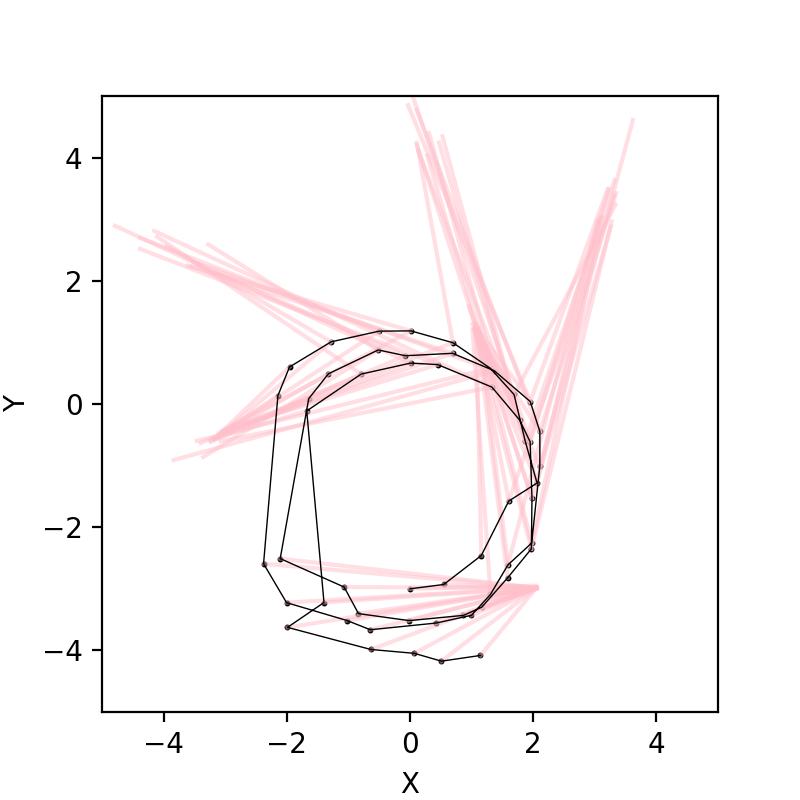

In [7]:
hat_xs, zlist = read_data() ###graphbasedslam5exec
dim = len(hat_xs)*3  #軌跡をつなげたベクトルの次元

for n in range(1,10000):  #10000は適当に大きな値にしておく（終了判定は別途下で）
    ##エッジ、大きな精度行列、係数ベクトルの作成##
    edges = make_edges(hat_xs, zlist) 
    Omega = np.zeros((dim, dim))
    xi = np.zeros(dim)
    Omega[0:3, 0:3] += np.eye(3)*1000000  #x0の固定

    ##軌跡を動かす量（差分）の計算##
    for e in edges:
        add_edge(e, Omega, xi) #エッジの精度行列、係数ベクトルをOmega, xiに足す

    delta_xs = np.linalg.inv(Omega).dot(xi) #求めた差分
    
    ##推定値の更新##
    for i in range(len(hat_xs)):
        hat_xs[i] += delta_xs[i*3:(i+1)*3]    #差分を足して新たな推定値を作る
        
    ##終了判定###
    delta = np.linalg.norm(delta_xs)           #差分の大きさ（L2ノルム）を求める
    print("{}回目の繰り返し: {}".format(n, delta))
    if delta < 0.01:                                        #閾値は調整する必要があるかもしれません
        draw(hat_xs, zlist, edges) #収束したら描画。drawでdraw_edgesを呼び出している行はコメントアウトしておく
        break